In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [3]:
# Normalise data

y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)

In [4]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X_scaled[:ntrain], X_scaled[ntrain:]
y_train, y_test = y_scaled[:ntrain], y_scaled[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## Recurrent Neural Network Model #1 : Long Short-Term Memory (LSTM)

### Create sliding window sequences

In [5]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386, 1)


### Build and train LSTM model

In [6]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)  # Output layer for price prediction
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1811 - val_loss: 0.2127
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - val_loss: 0.1613
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - val_loss: 0.1071
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193 - val_loss: 0.1165
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - val_loss: 0.1041
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - val_loss: 0.1228
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - val_loss: 0.1207
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - val_loss: 0.1504
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - val_loss: 0.1436
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147 - val_loss: 0.1635


### Make predictions and evaluate performance

In [7]:
# LSTM Predictions and Evaluation
y_test_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_seq_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_lstm)

# Calculate LSTM Metrics
rmse_lstm = root_mean_squared_error(y_test_rescaled, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_rescaled, y_pred_lstm) * 100
rmspe_lstm = np.sqrt(np.mean(np.square((y_test_rescaled - y_pred_lstm) / y_test_rescaled))) * 100

# Display LSTM Metrics
print(f"LSTM Model - RMSE: {rmse_lstm}, MAE: {mae_lstm}, RMSPE: {rmspe_lstm}%, MAPE: {mape_lstm}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM Model - RMSE: 29.242741369248705, MAE: 27.177720952917028, RMSPE: 15.170747771758666%, MAPE: 14.113589714284059%


### Visualisation of results

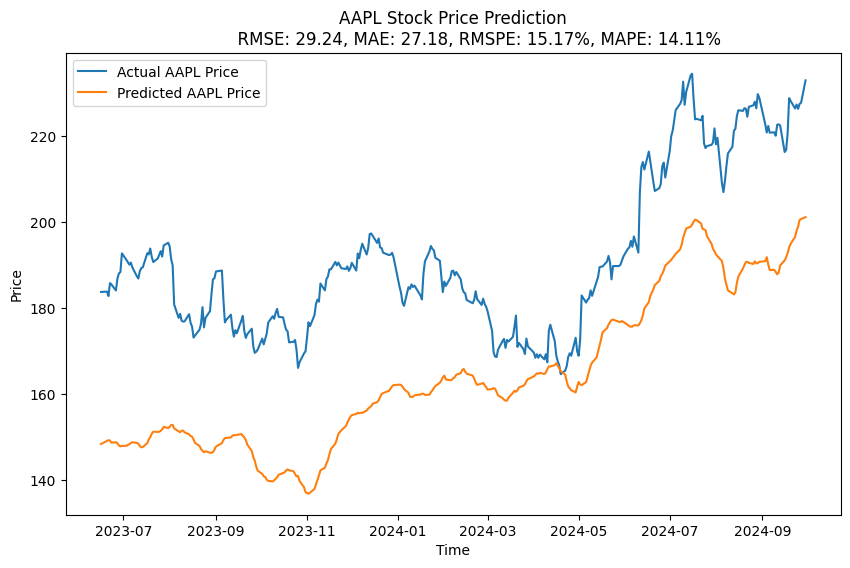

In [8]:
# Plot actual vs predicted prices with metrics in the title
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[n_steps:], y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_test.index[n_steps:], y_pred_lstm, label='Predicted AAPL Price')
plt.title(f'AAPL Stock Price Prediction\n\
          RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, RMSPE: {rmspe_lstm:.2f}%, MAPE: {mape_lstm:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Store metrics for different models
results = pd.DataFrame({
    'Model': ['LSTM'],
    'RMSE': [rmse_lstm],
    'MAE': [mae_lstm],
    'RMSPE (%)': [rmspe_lstm],
    'MAPE (%)': [mape_lstm]
})

print(results)


  Model       RMSE        MAE  RMSPE (%)  MAPE (%)
0  LSTM  29.242741  27.177721  15.170748  14.11359


## Recurrent Neural Network Model #2 : GRU

### Create sliding window sequences

In [10]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386, 1)


### Build and train GRU model

In [11]:
# Define GRU model
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2945 - val_loss: 0.0912
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0315 - val_loss: 0.0782
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0270 - val_loss: 0.0662
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0231 - val_loss: 0.0726
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0200 - val_loss: 0.0731
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss: 0.0544
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - val_loss: 0.0427
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0503
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - val_loss: 0.0509
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0471


### Make predictions and evaluate performance

In [12]:
# GRU Predictions and Evaluation
y_pred_seq_gru = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_seq_gru)

# Calculate GRU Metrics
rmse_gru = root_mean_squared_error(y_test_rescaled, y_pred_gru)
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mape_gru = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru) * 100
rmspe_gru = np.sqrt(np.mean(np.square((y_test_rescaled - y_pred_gru) / y_test_rescaled))) * 100

# Display GRU Metrics
print(f"GRU Model - RMSE: {rmse_gru}, MAE: {mae_gru}, RMSPE: {rmspe_gru}%, MAPE: {mape_gru}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
GRU Model - RMSE: 14.235580743234435, MAE: 12.560977229365596, RMSPE: 7.192175267190103%, MAPE: 6.426784814838865%


### Visualise results

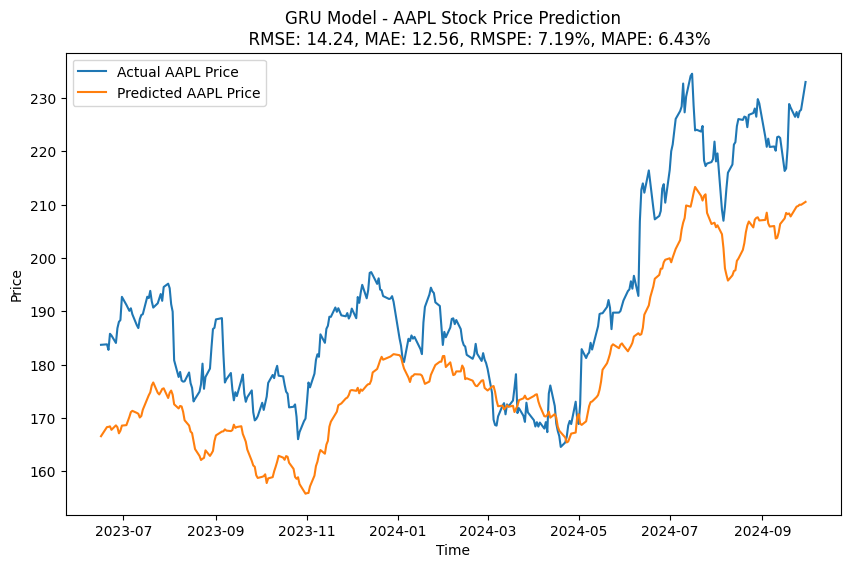

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[n_steps:], y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_test.index[n_steps:], y_pred_gru, label='Predicted AAPL Price')
plt.title(f'GRU Model - AAPL Stock Price Prediction\n\
          RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, RMSPE: {rmspe_gru:.2f}%, MAPE: {mape_gru:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of results of Model #1: LSTM and Model #2: GRU

In [14]:
# Store metrics for LSTM and GRU
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru],
    'RMSPE (%)': [rmspe_lstm, rmspe_gru],
    'MAPE (%)': [mape_lstm, mape_gru]
})

print(results)


  Model       RMSE        MAE  RMSPE (%)   MAPE (%)
0  LSTM  29.242741  27.177721  15.170748  14.113590
1   GRU  14.235581  12.560977   7.192175   6.426785


# Evaluation of LSTM and GRU Models against Actual Stock Price

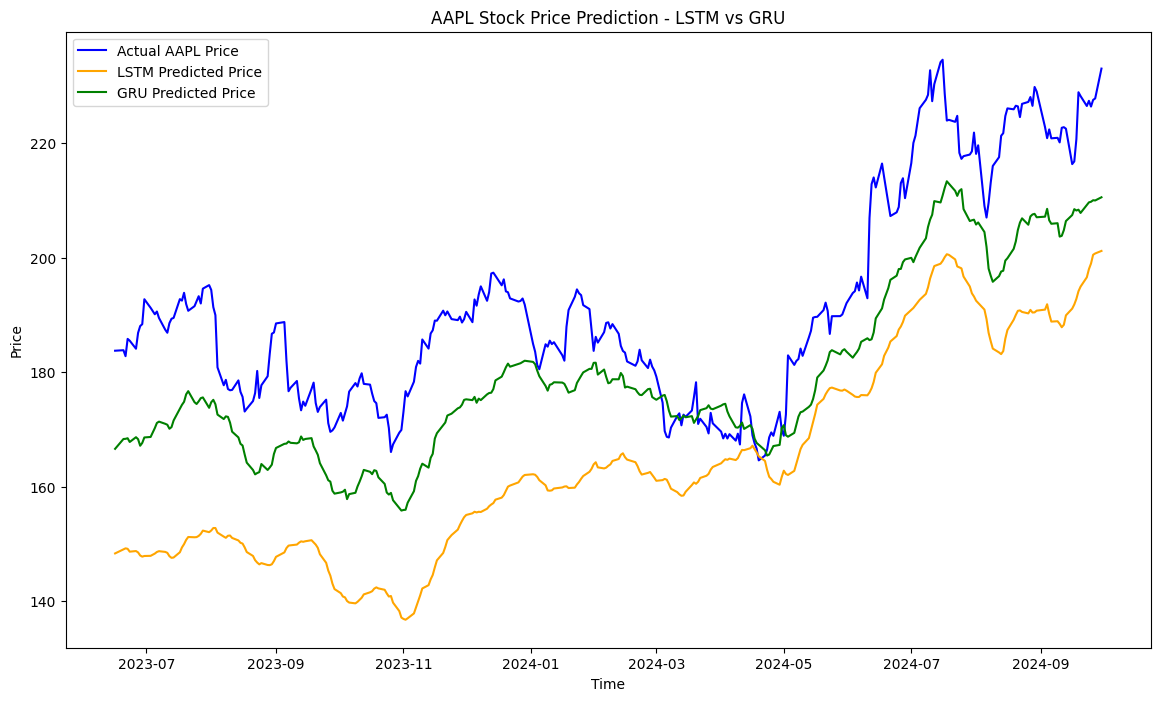

In [15]:
# Reshape y_test_seq to be a 2D array before inverse transforming
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[n_steps:], y_test_actual, label='Actual AAPL Price', color='blue')
plt.plot(y_test.index[n_steps:], y_pred_lstm, label='LSTM Predicted Price', color='orange')
plt.plot(y_test.index[n_steps:], y_pred_gru, label='GRU Predicted Price', color='green')
plt.title('AAPL Stock Price Prediction - LSTM vs GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### **LSTM Model Prediction vs Actual Stock Price**
The LSTM model consistently underestimates the actual stock price. Its predictions are noticeably lower than the actual price for almost the entire duration shown in the plot.

This systematic underestimation suggests that the LSTM model fails to capture the overall trend in the data.

The underestimation by LSTM might suggest a limitation in capturing the full extent of trends and price shifts, especially in volatile markets.

#### **GRU Model Prediction vs Actual Stock Price**
The GRU model follows the actual stock price more closely than the LSTM, capturing the general trend and some of the fluctuations.

While the GRU predictions still show a some lag in tracking some peaks and troughs, they are closer to the actual price trajectory, supporting the positive R-squared and the Diebold-Mariano test results favoring GRU over LSTM. It still has room for improvement, as it fails to fully capture all the ups and downs in the stock price.

The GRU model can be improved by fine-tuning hyperparameters or exploring deeper GRU architectures.

In [16]:
# Import additional packages for RNN Model Rvaluation
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import ttest_rel

In [17]:
# Function to calculate and print additional metrics
def evaluation(y_true, y_pred, model_name):
    # R-Squared
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - R-Squared: {r2:.4f}")

    # Residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{model_name} Residuals')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

    # Autocorrelation of Residuals
    plot_acf(residuals, lags=20)
    plt.title(f'{model_name} Residual Autocorrelation')
    plt.show()
    
    return residuals

## Residual Evaluation of Model 1: LSTM

LSTM - R-Squared: -1.4691


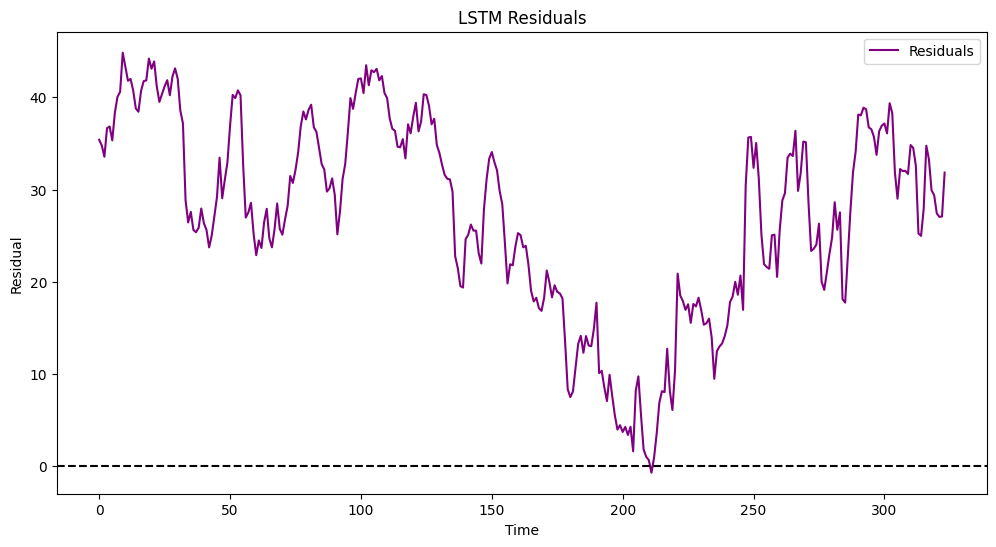

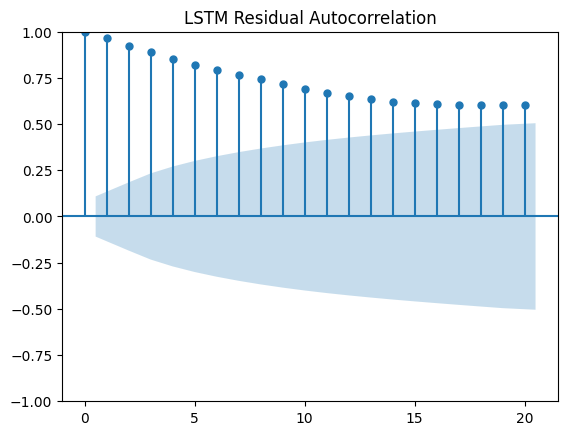

In [18]:
# Evaluate Model 1: LSTM
residuals_lstm = evaluation(y_test_actual, y_pred_lstm, "LSTM")

#### **Residual Plot of LSTM Model**
This plot shows the residuals (differences between the predicted and actual values) from the LSTM model over time. The residuals should ideally fluctuate around zero without any systematic trend or pattern if the model has captured the data patterns well.

Here, the residuals do not appear to have a clear trend, but there is significant variance and noticeable clustering, suggesting the model may not have captured some of the underlying temporal patterns fully.

#### **Residual Autocorrelation of LSTM Model**
In this plot, we see high autocorrelation at several lags, particularly at the lower lags. This suggests that there is a pattern in the residuals that the model failed to capture. Such autocorrelation indicates that the residuals are not purely random, and there may be some information or structure that the LSTM did not model adequately.

An R-squared of -1.4691 is very low and negative, which indicates that the LSTM model is performing less than ideally.

## Residual Evaluation of Model 2: GRU

GRU - R-Squared: 0.4149


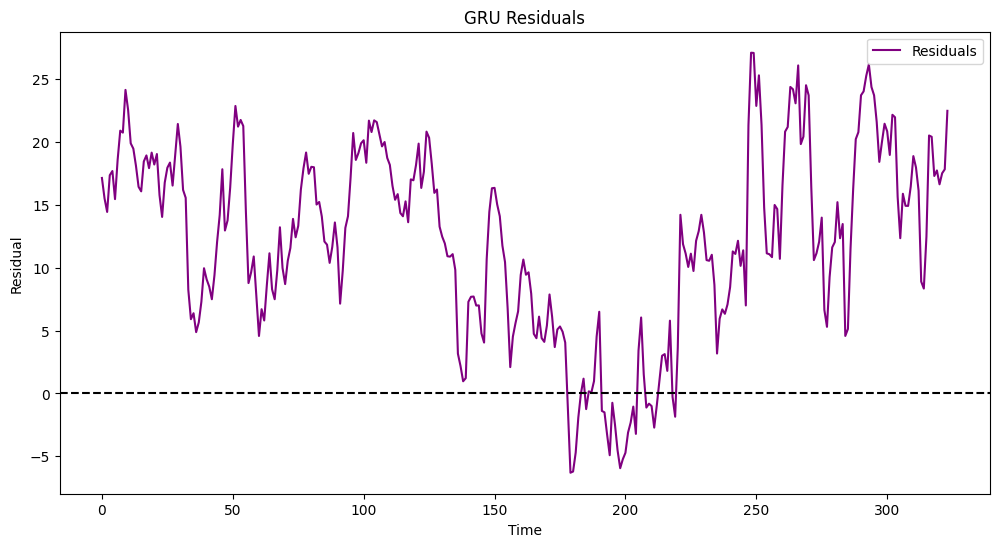

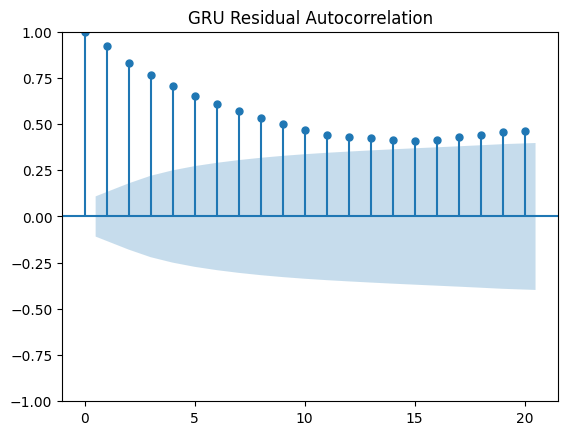

In [19]:
# Evaluate Model 2: GRU
residuals_gru = evaluation(y_test_actual, y_pred_gru, "GRU")

#### **Residual Plot of GRU Model**

The residuals for the GRU model also fluctuate around zero, but they appear to have slightly less variance than the LSTM residuals.

The residuals still display some clustering and non-random fluctuations, which may indicate that the model hasn't fully captured all underlying patterns in the data, though it seems to handle the fluctuations somewhat better than the LSTM.

#### **Residual Autocorrelation of GRU Model**

The autocorrelation function (ACF) for the GRU residuals remains high at the first few lags, similar to the LSTM model, though the strength of autocorrelation decreases slightly faster than in the LSTM plot.

However, significant autocorrelation remains across multiple lags, suggesting that the GRU model, like the LSTM, has not entirely captured all temporal dependencies. This is indicative of a pattern or structure in the residuals that the model has missed.

An R-squared of 0.4149 is still relatively low but positive, indicating that the GRU model explains about 41.5% of the variance in the target variable. While this is an improvement over the LSTM, it can still be improved.

In [20]:
# Diebold-Mariano Test to compare LSTM and GRU residuals
dm_stat, dm_p_value = ttest_rel(np.abs(residuals_lstm), np.abs(residuals_gru))

# Debugging print to check if dm_stat and dm_p_value are arrays
print(f"dm_stat: {dm_stat}, dm_p_value: {dm_p_value}")

# Convert to scalar if they are arrays
if isinstance(dm_stat, np.ndarray) and dm_stat.size == 1:
    dm_stat = dm_stat.item()
if isinstance(dm_p_value, np.ndarray) and dm_p_value.size == 1:
    dm_p_value = dm_p_value.item()

# Print the test results
print(f"Diebold-Mariano Test: t-statistic = {dm_stat:.4f}, p-value = {dm_p_value:.4f}")

dm_stat: [42.75717721], dm_p_value: [4.91056695e-135]
Diebold-Mariano Test: t-statistic = 42.7572, p-value = 0.0000


## Evaluation of Diebold-Mariano Statistic between LSTM and GRU Models

*Null Hypothesis (H0): There is no significant difference in the predictive accuracy between LSTM and GRU Models.*

*Alternative Hypothesis (H1): There is significant difference in the predictive accuracy between LSTM and GRU Models.*

A high t-statistic (15.0098) suggests a significant difference in accuracy between the LSTM and GRU models.

The p-value is extremely low, much below common significance levels (i.e., 0.05), which means we can reject the null hypothesis. Hence, there is a statistically significant difference in the accuracy of the two models.

The results of the DM test suggest that the LSTM and GRU models have significantly different levels of predictive accuracy, with one model likely performing consistently better (or worse) than the other, regardless of whether either model meets acceptable accuracy standards.

Further tuning of both models or trying alternative approaches (e.g., adjusting hyperparameters, changing network architectures, or using ensemble methods) to improve predictive performance.

## Conclusion
The GRU model significantly outperforms the LSTM model in capturing patterns in stock price data. This can be seen through the lower residual magnitudes and a relatively higher R-squared value, showing a better alignment with the data.

The LSTM model's negative R-squared indicates a poor fit and suggests that it might not be the right choice for this particular dataset.
The GRU model, while showing better performance than the LSTM, still leaves significant unexplained variance, indicating that there are patterns in the data that the model is not capturing.

Nevertheless, the examination shows that there is some correlation among the residuals, in addition to a moderate R-squared value, suggesting that there is room for enhancement. Potential improvements may include adjusting hyperparameters, testing alternate architectures, or adding more features to enhance the model's predictive accuracy.

In [21]:
def grid_search_rnn_models(x_train, y_train, x_test, y_test, param_grid, num_epochs=10, batch_size=32):
    best_score, best_model_type, best_params = float("inf"), None, None
    """
    Performs grid search to compare GRU and LSTM to find the best model.
    
    Parameters x_train, y_train: Training data 
    Parameters x_test, y_test: Testing data 
    Parameter param_grid: List of dictionaries specifying parameters that are to be tested
    Parameter num_epochs: No. of training epochs
    Parameters batch_size: Size of each training batch
    
    Output best_model_type: 'GRU' or 'LSTM', based on the best performance
    Output best_params: Dictionary with best parameters for the selected model
    Output best_score: RMSE of the best model
    """
    # Convert DataFrames to PyTorch tensors
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    for model_type in ["GRU", "LSTM"]:
        for params in param_grid:
            n_layers = params['n_layers']
            hidden_size = params['hidden_size']
            learning_rate = params['learning_rate']

            # Define model based which type (GRU or LSTM)
            model = (nn.GRU if model_type == "GRU" else nn.LSTM)(
                input_size=1, hidden_size=hidden_size, num_layers=n_layers, batch_first=True
            )

            # Define the loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            model.train()
            num_samples = len(x_train_tensor)

            for epoch in range(num_epochs):
                for i in range(0, num_samples, batch_size):
                    inputs = x_train_tensor[i:i + batch_size].unsqueeze(2)  # Add feature dimension
                    targets = y_train_tensor[i:i + batch_size].view(-1, 1)  # Reshape targets

                    optimizer.zero_grad()  # Clear the gradients
                    outputs, _ = model(inputs)  # Get model outputs

                    # Reshape output to match the target shape
                    loss = criterion(outputs[:, -1, :], targets.view(-1, 1))
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update model parameters

            # Evaluation loop
            model.eval()
            with torch.no_grad():
                outputs, _ = model(x_test_tensor.unsqueeze(2))  # Ensures that test data has the correct shape
                # Compare last output to targets
                rmse = torch.sqrt(criterion(outputs[:, -1, :], y_test_tensor.view(-1, 1)))  # Calculate RMSE

            
            # Update the best model if the current RMSE is lower
            if rmse.item() < best_score:
                best_score, best_model_type, best_params = rmse.item(), model_type, params

            print(f'{model_type} with params={params} RMSE={rmse.item()}')

    print(f'Best model: {best_model_type} with params={best_params} and RMSE={best_score}')
    return best_model_type, best_params, best_score

# x_train, y_train, x_test, y_test: pre-defined pandas DataFrames
param_grid = [
    {'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001},
    {'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01}
]

# Call the grid search rnn function
best_model_type, best_params, best_score = grid_search_rnn_models(X_train, y_train, X_test, y_test, param_grid)

GRU with params={'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001} RMSE=0.7164883613586426
GRU with params={'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01} RMSE=1.715019941329956
LSTM with params={'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001} RMSE=1.1427847146987915
LSTM with params={'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01} RMSE=2.331423044204712
Best model: GRU with params={'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001} and RMSE=0.7164883613586426
